In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from itertools import combinations
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from prince import MCA
from sklearn.ensemble import IsolationForest
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from scipy.stats import uniform
#from c45 import C45

# splite continuous and categorical data for further analysis

In [2]:
data = pd.read_excel("tr.xlsx")

In [3]:
np.sort(data.nunique().unique())

array([  2,   3,   4,   6,  14,  16,  58,  86, 103, 109, 132, 170, 205,
       206, 229, 245, 274, 299, 316, 339, 350, 381, 428, 514, 516, 570,
       852], dtype=int64)

In [4]:
data_conti = data.iloc[:,np.where(data.nunique()>20)[0]]
data_cat = data.iloc[:,np.where(data.nunique()<=20)[0]]
target = data_cat.iloc[:,0]
data_cat = data_cat.iloc[:,1:]

In [5]:
data[data.columns[data.nunique()==16]].value_counts()

cci_index
0            35002
1             8003
2             4343
3             2301
4             1172
5              656
6              289
8              131
7              117
9               84
10              29
11              13
12              12
13               4
14               2
15               1
dtype: int64

# Dealing with categorical data

In [6]:
data_cat.iloc[:,np.where(data_cat.isnull().sum()>0)[0]].isnull().sum()/len(data_cat)

SEX    0.001802
ASA    0.386472
dtype: float64

In [7]:
data_cat.SEX.value_counts()/len(data_cat)

F    0.666922
M    0.331276
Name: SEX, dtype: float64

In [8]:
data_cat.SEX = data_cat.SEX.fillna("F")

data_cat = data_cat[data_cat.columns[np.where((data_cat.isnull().sum()/len(data))<0.3)]]

# MCA for categorical data dimensionality reduction for anomaly detection

In [9]:
mca = MCA(n_components = data_cat.shape[1])
mca.fit(data_cat)

MCA(n_components=44)

In [10]:
data_cat_mca = mca.transform(data_cat).iloc[:,[i for i in range(np.where((np.cumsum(mca.explained_inertia_)/np.sum(mca.explained_inertia_))>0.9)[0][0])]]

# Delete continuous data with NA value over 30% (paper supported)

In [11]:
print(data_conti.columns[np.where((data_conti.isnull().sum()/len(data))<0.3)])
data_conti = data_conti[data_conti.columns[np.where((data_conti.isnull().sum()/len(data))<0.3)]]

Index(['AGE', 'LOS'], dtype='object')


# Examine proportion of outcome

In [12]:
data["outcome"].value_counts()

0    51280
1      879
Name: outcome, dtype: int64

# Continuous data EDA

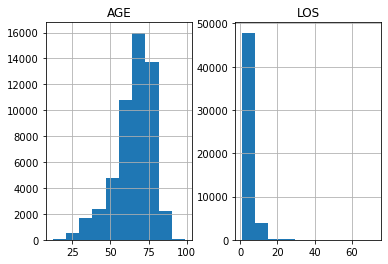

In [13]:
data_conti.hist()
plt.show()

In [14]:
data_conti.LOS = np.log(data_conti.LOS)

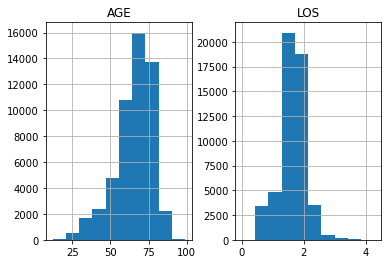

In [15]:
data_conti.hist()
plt.show()

In [16]:
data_conti.corr()

,AGE,LOS
AGE,1.000000,0.030688
LOS,0.030688,1.000000


# Standardization on continuous data

In [17]:
data_conti = (data_conti - data_conti.mean())/data_conti.std()

In [18]:
data_conti = data_conti.fillna(0)

# Anomaly detection

In [19]:
data_isotr = pd.concat([data_conti,data_cat_mca],axis=1).to_numpy()

In [20]:
lst = np.zeros(len(data_isotr))
for _ in range(100):
    clf = IsolationForest()
    clf.fit(data_isotr)
    ind = np.where(clf.predict(data_isotr) == -1)[0]
    lst[ind] += 1

In [21]:
I = []
for i in [i for i in range(len(data_isotr))]:
    if i not in np.where(lst>50)[0]:
        I.append(i)

D:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


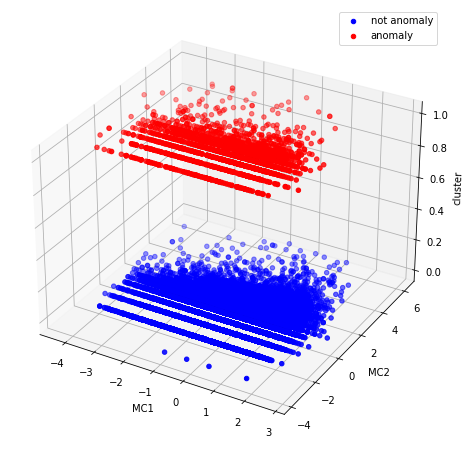

In [122]:
# outlier設定
I = np.array(I)
drop_ind = np.where(lst>50)[0]
# 圖形設定
plt.figure(figsize = (10, 8))
ax = plt.gca(projection='3d')
# 各類別畫圖
## 非outlier
X = data_isotr[I,0]
Y = data_isotr[I,1]
Z = [0 for i in range(len(I))]
ax.scatter(X, Y, Z, marker = 'o', color = 'blue', label = 'not anomaly')
## 是outlier
X = data_isotr[drop_ind,0]
Y = data_isotr[drop_ind,1]
Z = [1 for i in range(len(drop_ind))]
ax.scatter(X, Y, Z, marker = 'o', color = 'red', label = 'anomaly')
## 類別1
III = np.where(target == 1)[0]
X = data_isotr[III,0]
Y = data_isotr[III,1]
Z = [2 for i in range(len(III))]
#ax.scatter(X, Y, Z, marker = 'o', color = 'orange', label = 'class 1')

ax.set_xlabel('MC1')
ax.set_ylabel('MC2')
ax.set_zlabel('cluster')
ax.legend()
plt.show()

In [23]:
data_conti = data_conti.drop(drop_ind)
data_cat = data_cat.drop(drop_ind)
target = target.drop(drop_ind)

# Chi square for categorical data

In [24]:
def del_cat(pd_data_cat):
    comb = combinations([i for i in range(pd_data_cat.shape[1])],2)
    comb = list(comb)

    chi_re = []
    for i in comb:
        re = []
        re.append(pd_data_cat.columns[i[0]])
        re.append(pd_data_cat.columns[i[1]])
        re.append(chi2_contingency(np.array(pd.crosstab(pd_data_cat.iloc[:,i[0]], pd_data_cat.iloc[:,i[1]])))[1])
        chi_re.append(re)

    cat_col = pd_data_cat.columns
    cat_count = np.array([0 for i in range(len(cat_col))])

    for i in chi_re:
        if i[2] < 0.05:
            cat_count[np.where(cat_col == i[0])[0]] += 1
            cat_count[np.where(cat_col == i[1])[0]] += 1
            
    return pd_data_cat.drop([cat_col[np.argmax(cat_count)]],axis=1)

def chi_2(pd_data_cat):
    comb = combinations([i for i in range(pd_data_cat.shape[1])], 2)
    comb = list(comb)
    chi_re = []
    for i in comb:
        re = []
        re.append(pd_data_cat.columns[i[0]])
        re.append(pd_data_cat.columns[i[1]])
        re.append(chi2_contingency(np.array(pd.crosstab(pd_data_cat.iloc[:,i[0]], pd_data_cat.iloc[:,i[1]])))[1])
        chi_re.append(re)
    cat_col = pd_data_cat.columns
    cat_count = np.array([0 for i in range(len(cat_col))])
    for i in chi_re:
        if i[2] < 0.05:
            cat_count[np.where(cat_col == i[0])[0]] += 1
            cat_count[np.where(cat_col == i[1])[0]] += 1
    
    return cat_count

def oversample(data):
    over_len = len(np.where(data.outcome==0)[0])-len(np.where(data.outcome==1)[0])
    ind = np.random.choice(np.where(data.outcome==1)[0], over_len)
    
    #data_over = data_clean.iloc[np.random.randint(0,len(np.where(data_clean.outcome==1)[0])),:]
    #for _ in range(over_len - 1):
        #data_over = pd.concat([data_over,data_clean.iloc[np.random.randint(0,len(np.where(data_clean.outcome==1)[0])),:]],axis = 1)
    return pd.concat([data.iloc[ind,:], data], axis = 0)

In [25]:
while np.sum(chi_2(data_cat) > 0):
    data_cat = del_cat(data_cat)

In [26]:
del_cat_y = []
for i in range(data_cat.shape[1]):
    chi2_re = chi2_contingency(np.array(pd.crosstab(data_cat.iloc[:,i], target)))[1]
    if chi2_re > 0.05:
        del_cat_y.append(data_cat.columns[i])
        #data_cat_f = data_cat.drop([data_cat.columns[i]],axis = 1)

In [27]:
data_cat_f = data_cat.drop(del_cat_y,axis = 1)

In [28]:
for i in range(data_cat_f.shape[1]):
    print(data_cat_f.iloc[:,i].value_counts())

0    47814
1     2048
Name: Rheumatoid Arthritis/collagen, dtype: int64
0    49860
1        2
Name: Weight Loss, dtype: int64
0    49592
1      270
Name: Alcohol Abuse, dtype: int64


In [29]:
#one-hot後會讓NA的vecter都是0
#data_cat_onehot = pd.get_dummies(data_cat, columns = data_cat.columns, drop_first = True)

# SMOTENC on training data

In [126]:
X = pd.concat([data_conti, data_cat_f], axis = 1)
y = target

#X_train, X_val, y_train, y_val = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.33, random_state = 1)

In [142]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold

def Parameters(pars, values, n):
    # pars：參數名稱
    # 參數取值
    # n：要挑幾組
    '''if type(pars!=list):
        raise ValueError('Input type of pars should be a list')
    if type(values!=list):
        raise ValueError('Input type of values should be a list')'''
    if (len(pars)!=len(values)):
        raise ValueError('pars and values should have same length')
    
    para_dict = []
    for i in range(n):
        vlist = []
        for p in range(len(pars)):
            v = np.random.choice(values[p])
            vlist.append(v)
        choice = dict(zip(pars, vlist))
        para_dict.append(choice)
    return para_dict

def best_thr(y_true, y_prob):
    precs, recs, thrs = precision_recall_curve(y_true, y_prob)
    f1s = 2 * precs * recs / (precs + recs)
    f1s = f1s[:-1]
    thrs = thrs[~np.isnan(f1s)]
    f1s = f1s[~np.isnan(f1s)]
    best_thr = thrs[np.argmax(f1s)]
    #f1_score = np.max(f1s)
    return best_thr#, f1_score

def HPSearch(X, y, param_dict, k, cate_idx, classifier):
    # param_dict 是 函數 Parameters 的 output，list of parameter dictionary
    # cate_idx:類別變數的column index
    # scoring：score function
    X = np.array(X)
    y = np.array(y)
    F1_all = []
    thr_all = []
    f1_all = []
    for param in param_dict: 
        print(param)
        cv = StratifiedKFold(n_splits=k)
        F1 = []
        thr_lst = []
        for train_idx, test_idx, in cv.split(X, y):
            #print(len(train_idx), len(test_idx))
            X_res, y_res = X[train_idx,:], y[train_idx]
            X_ts, y_ts = X[test_idx,:], y[test_idx]
            '''
            if (cate_idx=='None'):
                sm = SMOTE(random_state=1)
            else:
                sm = SMOTENC(categorical_features=cate_idx)
            X_res, y_res = sm.fit_resample(X_tr, y_tr)
            
            '''
            
            if (classifier=='RF'):
                clf = RandomForestClassifier(**param)
            elif (classifier=='SVM'):
                clf = SVC(**param)
            elif (classifier=='LG'):
                clf = LogisticRegression(**param)
            elif (classifier=='DT'):
                clf = DecisionTreeClassifier(**param)
                
            clf.fit(X_res, y_res)
            thr = best_thr(y_res,clf.predict_proba(X_res)[:,1])
            y_pred = (clf.predict_proba(X_ts)[:,1]>thr).astype(int)
            #print(len(y_pred))
            F1.append(f1_score(y_ts, y_pred))
            thr_lst.append(thr)
        F1_all.append(np.mean(F1))
        f1_all.append(F1)
        thr_all.append(thr_lst)
    best = np.argmax(F1_all)
    best_param = param_dict[best]
    
    return best_param#, F1_all, f1_all, thr_all

In [143]:
rfPars = Parameters(['n_estimators','max_depth','max_features'], [range(100,300,1), range(5,15,1), ['sqrt', 'log2']], 5)
print(rfPars)
#clf = RandomForestClassifier(**rfPars[0])
#clf.fit(X, y)

[{'n_estimators': 202, 'max_depth': 13, 'max_features': 'sqrt'}, {'n_estimators': 297, 'max_depth': 10, 'max_features': 'log2'}, {'n_estimators': 192, 'max_depth': 11, 'max_features': 'sqrt'}, {'n_estimators': 226, 'max_depth': 10, 'max_features': 'sqrt'}, {'n_estimators': 252, 'max_depth': 5, 'max_features': 'sqrt'}]


In [144]:
best_rf = HPSearch(X, y, rfPars, 3, list(np.arange(2,X.shape[1])), 'RF')

{'n_estimators': 202, 'max_depth': 13, 'max_features': 'sqrt'}
{'n_estimators': 297, 'max_depth': 10, 'max_features': 'log2'}
{'n_estimators': 192, 'max_depth': 11, 'max_features': 'sqrt'}
{'n_estimators': 226, 'max_depth': 10, 'max_features': 'sqrt'}
{'n_estimators': 252, 'max_depth': 5, 'max_features': 'sqrt'}


In [148]:
clf = RandomForestClassifier(**a)
clf.fit(X.to_numpy(), y.to_numpy())
thr = best_thr(y,clf.predict_proba(X.to_numpy())[:,1])

In [31]:
sm = SMOTENC(categorical_features = [i for i in range(2, X.shape[1])])
X_res, y_res = sm.fit_resample(X, y)

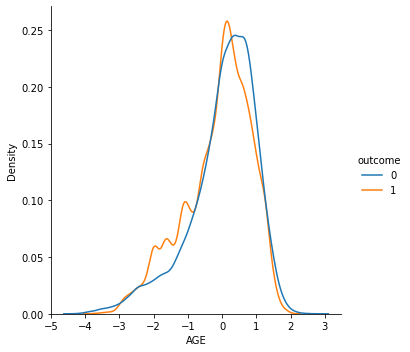

In [32]:
sns.displot(pd.concat([X_res, y_res],axis = 1),x="AGE", kind = "kde", hue ="outcome")

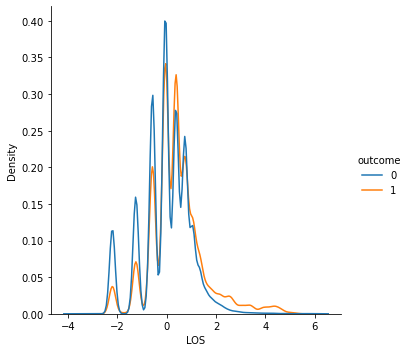

In [33]:
sns.displot(pd.concat([X_res, y_res],axis = 1),x="LOS", kind = "kde", hue ="outcome")

# Modeling

In [ ]:
dt_para = {"max_depth": range(4, 20, 2)}
dt_cv = RandomizedSearchCV(DecisionTreeClassifier(), dt_para, scoring = "f1", cv = 5)


rf_para = {"max_depth": range(4, 20, 2), 
            "n_estimators": [int(x) for x in range(100, 1000, 50)]}
rf_cv = RandomizedSearchCV(RandomForestClassifier(), rf_para, scoring = "f1", cv = 5)

lr_para = {"C": uniform(loc=0, scale=100), "penalty":["l1","l2","elasticnet"]}
lr_cv = RandomizedSearchCV(LogisticRegression(), lr_para, scoring = "f1", cv = 5)

svm_para = {'C': uniform(loc=0, scale=100), 'gamma': uniform(loc=0, scale=100),'kernel': ['rbf', 'poly', 'sigmoid']}
svm_cv = RandomizedSearchCV(SVC(), svm_para, scoring = "f1", cv = 5)


dt_cv.fit(X_res, y_res)
rf_cv.fit(X_res, y_res)
lr_cv.fit(X_res, y_res)
svm_cv.fit(X_res, y_res)

C:\Users\User\.conda\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\User\.conda\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\.conda\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\.conda\envs\tf\lib\site-packages\sklear

In [37]:
from keras.layers import Dense, Activation, Conv1D, Dropout, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import Sequential

In [38]:
def CNN_firstlayer(model,neuron,fun):
    model.add(Conv1D(neuron, 2, input_shape=(X_res.shape[1], 1))) # 2 means kernal size
    model.add(BatchNormalization())
    model.add(Activation(fun))
    return model

def CNN_layer(model,neuron,fun):
    model.add(Conv1D(neuron, 2))
    model.add(BatchNormalization())
    model.add(Activation(fun)) 
    return model

def CNN_gen(layer,neuron,fun):
    model=Sequential()
    model=CNN_firstlayer(model,neuron,fun)
    for i in range(2,layer+1,1):
        model=CNN_layer(model,neuron,fun)
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid', name='output'))
    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 30)]
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['binary_accuracy'])
    model.fit(X_res, y_res, epochs=50, validation_split=0.2, batch_size=512, callbacks=callbacks,verbose=0)
    return model

In [39]:
m = CNN_gen(4, 4, "relu")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [51]:
neuron = 4
model=Sequential()

#input layer
model.add(Conv1D(neuron, 2, input_shape=(X_res.shape[1], 1), activation = 'relu')) # 2 means kernal size
model.add(BatchNormalization())

#second layer
model.add(Conv1D(neuron, 2, activation = 'relu'))
model.add(BatchNormalization())

#third layer
model.add(Conv1D(neuron, 2, activation = 'relu'))
model.add(BatchNormalization())

#last layer
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

#compile settings
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 30)]
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['binary_accuracy'])
model.fit(X_res, y_res, epochs=50, validation_split=0.2, batch_size=512, callbacks=callbacks,verbose=1)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
151/154 [============================>.] - ETA: 0s - loss: 0.6969 - binary_accuracy: 0.5907WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000219958B1E58> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

In [50]:
np.sum(m.predict(X)<0.02)

0

In [ ]:
from keras import Input
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from keras import Model
Feats = x_Train.shape[1]
layer0 = Input(shape = (Feats, 1));print(layer0.shape)
layer1 = Conv1D(filters = 8, kernel_size = 3, input_shape = (Feats, 1), activation = 'relu')(layer0); print(layer1.shape)
layer2 = MaxPooling1D(pool_size = 2, input_shape = layer1.shape[1:], strides = None, padding = "valid")(layer1); print(layer2.shape)
layer3 = Conv1D(filters = 4, kernel_size = 3, input_shape = layer2.shape[1:], activation = 'relu')(layer2); print(layer3.shape)
layer4 = MaxPooling1D(pool_size = 2, input_shape = layer3.shape[1:], strides = None, padding = "valid")(layer3); print(layer4.shape)
layer5 = Flatten()(layer4); print(layer5.shape)
layer6 = Dense(1, activation='sigmoid')(layer5); print(layer6.shape)

# perform same data preprocessing on unknown label testing dataset

In [ ]:
test = pd.read_csv("Project#1_ts.csv")

In [ ]:
test = test[X.columns[1:]]

In [ ]:
test.LOS = np.log(test.LOS)

In [ ]:
test.iloc[:,[0,1]] = (test.iloc[:,[0,1]] - test.iloc[:,[0,1]].mean())/test.iloc[:,[0,1]].std()

In [ ]:
test.isnull().sum()

In [ ]:
test = test.fillna(0)

In [ ]:
test.to_csv("test.csv", header = False, index = False)
test.to_csv("test.data", header = False, index = False)
test.to_csv("test.test", header = False, index = False)

In [ ]:
clf = C45(attrNames = X.columns)

In [ ]:
clf.fit(X_train_over, y_train_over)

In [ ]:
#without over sample/ without std
print('Training Accuracy:', accuracy_score(y_train_over, y_train_pred))
print('Testing Accuracy:', accuracy_score(y_test, y_test_pred))
print("-"*40)
print('Training F1:', f1_score(y_train_over, y_train_pred))
print('Testing F1:', f1_score(y_test, y_test_pred))

In [ ]:
#without over sample/ with std
print('Training Accuracy:', accuracy_score(y_train, y_train_pred))
print('Testing Accuracy:', accuracy_score(y_test, y_test_pred))
print("-"*40)
print('Training F1:', f1_score(y_train, y_train_pred))
print('Testing F1:', f1_score(y_test, y_test_pred))

In [ ]:
#over sample/ with std
print('Training Accuracy:', accuracy_score(y_train, y_train_pred))
print('Testing Accuracy:', accuracy_score(y_test, y_test_pred))
print("-"*40)
print('Training F1:', f1_score(y_train, y_train_pred))
print('Testing F1:', f1_score(y_test, y_test_pred))